For SARIMAX: 
  - Check for insignificant regressors (high p-values).
  - Check for multicollinearity (via Variance Inflation Factor – VIF).
  - Compare models with/without certain variables using AIC/BIC.

ACF vs STL:

| ACF (Autocorrelation Function)                   | STL (Seasonal-Trend decomposition using Loess)           |
| ------------------------------------------------ | -------------------------------------------------------- |
| Correlation of the series with its own past lags | Decomposes the series into trend, seasonality, residuals |
| Correlation values for lags                      | Separate time series: trend, seasonal, residual          |
| Identify autocorrelation and seasonality lags (model lags)    | Visualize and quantify seasonal and trend components     |
| Bar plot of correlations (ACF/PACF plots)        | Time series line plots of components                     |
| Peaks at lags = recurring cycles                 | Direct view of what the trend and seasonality look like  |


# ARIMA vs SARIMA vs SARIMAX

## ARIMA

Non-seasonal patterns in your time series. (p, d, q):
  - p: AR (AutoRegressive)	- How many past values (lags) the model uses to predict the current value.
  - d: Differencing - Number of times to difference the series to remove trend and make it stationary (statistical properties do not change over time: Constant mean, Constant variance, Constant autocorrelation structure)
  - q: MA (Moving Average)	- How many past forecast errors (residuals) the model uses


## SARIMA: Seasonal ARIMA

Add seasonal patterns (e.g., weekly or annual cycles) on top of ARIMA. seasonal_order=(P, D, Q, s):
  - P: Seasonal AR	- how many seasonal lags to include ("Admissions today ≈ a × Admissions 7 days ago")
  - D: Seasonal differencing - How many times to subtract seasonally (e.g., subtract value from 7 days ago)
  - Q: Seasonal MA - Use errors from prior seasonal lags to correct predictions
  - s: 	Seasonal period - 	The length of the seasonal cycle (e.g., s=7 for weekly data)

## SARIMA + exogenous variables

xog=X -> optional DataFrame of exogenous features


# Links
- https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html
- https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
- https://medium.com/data-science/time-series-forecasting-using-auto-arima-in-python-bb83e49210c

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import time


In [2]:
# Define metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100 / len(y_true) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head(5)

,DayOfWeek,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,IsDayAfterHoliday,temp_max,temp_min,temp_mean,humidity_max,humidity_min,NUMBER_INT,CO,MP10,O3,MP2.5,SO2
Date,,,,,,,,,,,,,,,,,,
2015-01-01,Thu,3,1,1,0,1,0,33.9,20.6,25.912500,89.0,32.0,30,0.0,NaN,68.0,NaN,82.0
2015-01-02,Fri,4,1,1,0,0,1,32.9,21.0,26.050000,87.0,38.0,43,0.0,NaN,79.0,NaN,83.0
2015-01-03,Sat,5,1,1,1,0,0,33.5,20.2,26.683333,83.0,38.0,23,0.0,NaN,44.0,NaN,83.0
2015-01-04,Sun,6,1,1,1,0,0,30.6,22.2,25.641667,81.0,43.0,20,0.0,NaN,49.0,NaN,82.0
2015-01-05,Mon,0,2,1,0,0,0,30.8,20.8,25.520833,79.0,36.0,51,0.0,NaN,59.0,NaN,82.0


In [4]:
# Time split: train = first 4 years, test = 5th year
min_year = df.index.year.min()
train_mask = df.index.year < (min_year + 4)
val_mask = df.index.year == (min_year + 4)

y_train = df.loc[train_mask, 'NUMBER_INT']
y_val = df.loc[val_mask, 'NUMBER_INT']

y_train.count()

1461

## ACF/PACF ADF

Augmented Dickey-Fuller test. Statistical test used to determine if a time series is stationary (i.e., its properties don't change over time).

In [5]:
y_train_diff = y_train.diff().dropna()

adf_original = adfuller(y_train)
adf_diff = adfuller(y_train_diff)

print("ADF Test (Original Series)")
print(f"Test Statistic: {adf_original[0]:.4f}")
print(f"p-value: {adf_original[1]:.4f}")
print("Stationary" if adf_original[1] < 0.05 else "Not Stationary")


ADF Test (Original Series)
Test Statistic: -2.7452
p-value: 0.0665
Not Stationary


In [6]:
print("\nADF Test (First-Differenced Series)")
print(f"Test Statistic: {adf_diff[0]:.4f}")
print(f"p-value: {adf_diff[1]:.4f}")
print(" Stationary" if adf_diff[1] < 0.05 else " Not Stationary")


ADF Test (First-Differenced Series)
Test Statistic: -8.9545
p-value: 0.0000
 Stationary


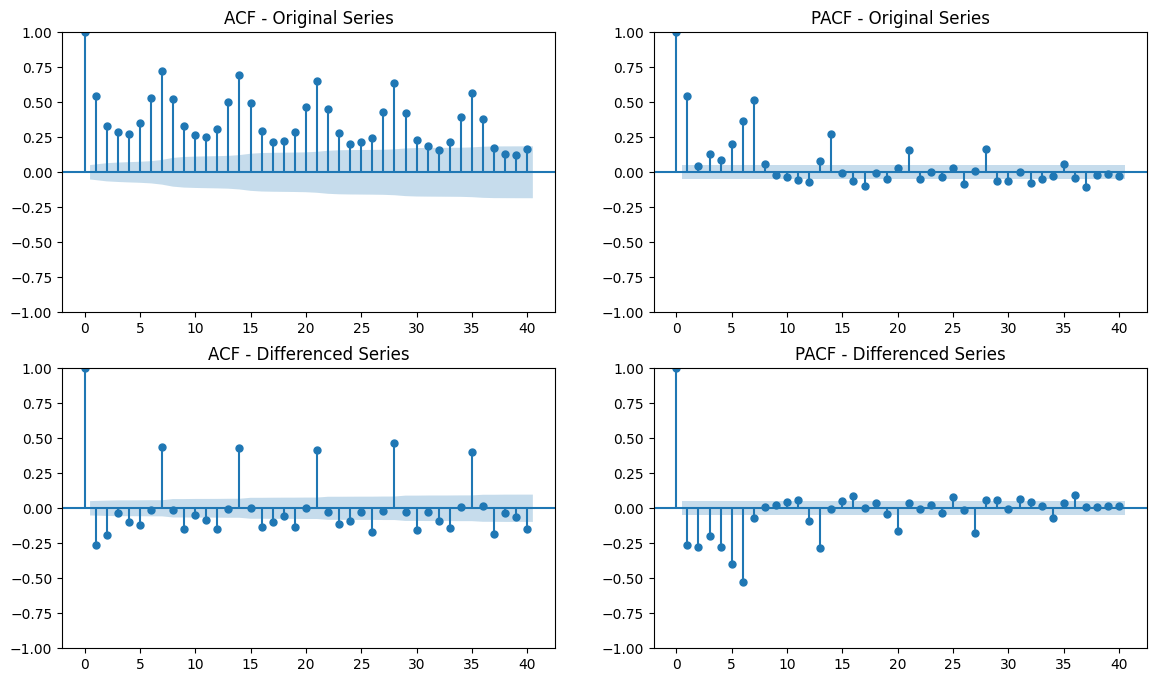

In [7]:
# --- Plot ACF and PACF ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

plot_acf(y_train, ax=axes[0, 0], lags=40, title='ACF - Original Series')
plot_pacf(y_train, ax=axes[0, 1], lags=40, title='PACF - Original Series')

plot_acf(y_train_diff, ax=axes[1, 0], lags=40, title='ACF - Differenced Series')
plot_pacf(y_train_diff, ax=axes[1, 1], lags=40, title='PACF - Differenced Series')

plt.show()

Based on visual inspection of ACF and PACF plots, along with ADF test results ( need for first differencing). The ARIMA model space was defined with non-seasonal orders (p, d, q) up to (3, 1, 3) and seasonal orders (P, D, Q) up to (2, 1, 2), across multiple seasonal periods. 

In [8]:
import warnings
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed")

start_time = time.time()

model = auto_arima(
    y_train,
    seasonal=True,
    m=7,
    start_p=0, max_p=15,
    start_q=0, max_q=15,
    max_d=1,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    max_D=1,
    stepwise=False, # Exhaustive search
    trace=False,
    # suppress_warnings=True,
    # error_action="ignore"
)

end_time = time.time()
elapsed = end_time - start_time
print(f"\nTraining time: {elapsed:.2f} seconds")


Training time: 260.82 seconds


## Metrics for 1 year

MAE:   10.94
RMSE:  13.62
MAPE:  22.18%
SMAPE: 21.62%
R^2:   0.22
Corr:  0.51
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1461
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -5318.817
Date:                             Tue, 13 May 2025   AIC                          10651.633
Time:                                     00:34:37   BIC                          10688.641
Sample:                                 01-01-2015   HQIC                         10665.438
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1762      0

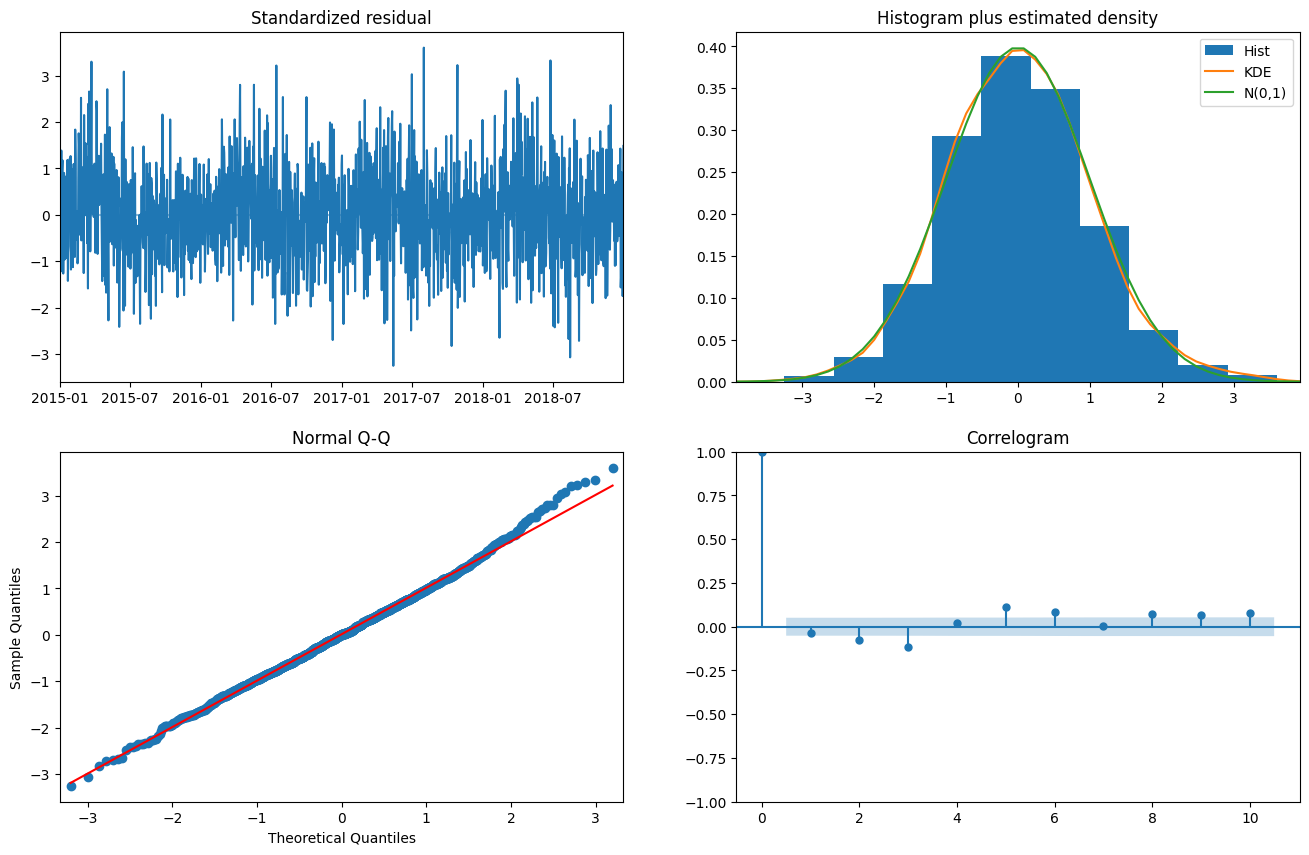

In [9]:
# Evaluate the model 1y
n_val = len(y_val)

forecast = model.predict(n_periods=n_val)

# Evaluation metrics
mse = mean_squared_error(y_val, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, forecast)
mape_val = mape(y_val, forecast)
smape_val = smape(y_val, forecast)
r2 = r2_score(y_val, forecast)
corr = np.corrcoef(y_val, forecast)[0, 1]

print(f"MAE:   {mae:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MAPE:  {mape_val:.2f}%")
print(f"SMAPE: {smape_val:.2f}%")
print(f"R^2:   {r2:.2f}")
print(f"Corr:  {corr:.2f}")

print(model.summary())

model.plot_diagnostics(figsize=(16, 10))
plt.show()

## Metrics for 30 days

In [10]:
print(f"\n## Metrics for 30 days:")
forecast_30 = model.predict(n_periods=30)

# Evaluation metrics 30
mse = mean_squared_error(y_val[:30], forecast_30)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val[:30], forecast_30)
mape_val = mape(y_val[:30], forecast_30)
smape_val = smape(y_val[:30], forecast_30)
r2 = r2_score(y_val[:30], forecast_30)
corr = np.corrcoef(y_val[:30], forecast_30)[0, 1]

print(f"MAE:   {mae:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MAPE:  {mape_val:.2f}%")
print(f"SMAPE: {smape_val:.2f}%")
print(f"R^2:   {r2:.2f}")
print(f"Corr:  {corr:.2f}")


## Metrics for 30 days:
MAE:   10.96
RMSE:  12.58
MAPE:  30.60%
SMAPE: 25.21%
R^2:   -1.36
Corr:  0.72


# Graph forecast vs validation

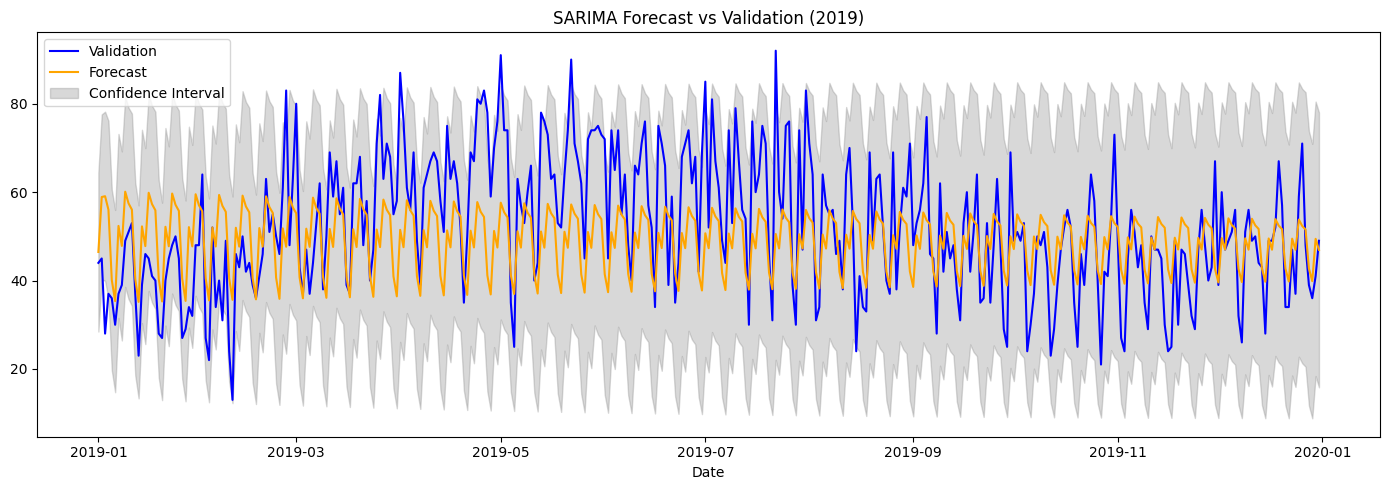

In [11]:
# Graph forecast vs validation
forecast_ci = model.predict(n_periods=n_val, return_conf_int=True)

forecast_values, conf_int = forecast_ci

forecast_index = y_val.index


plt.figure(figsize=(14, 5))
plt.plot(forecast_index, y_val, label="Validation", color="blue")
plt.plot(forecast_index, forecast_values, label="Forecast", color="orange")
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], 
                color='gray', alpha=0.3, label='Confidence Interval')
plt.title(f"SARIMA Forecast vs Validation ({forecast_index[0].year})")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

# SARIMAX

In [12]:
from statsmodels.tsa.stattools import grangercausalitytests

# Select your candidate exogenous variables
candidate_vars = ['IsWeekend', 'IsHoliday', 'IsDayAfterHoliday',
                  'temp_max', 'temp_min', 'humidity_min', 'humidity_max']

# Create a DataFrame with just those + target
df_test = df[['NUMBER_INT'] + candidate_vars].dropna()

max_lag = 3

for var in candidate_vars:
    print(f"\nTesting Granger causality: {var} --> NUMBER_INT")
    result = grangercausalitytests(df_test[['NUMBER_INT', var]], maxlag=max_lag, verbose=False)
    for lag in range(1, max_lag + 1):
        p_value = result[lag][0]['ssr_chi2test'][1]
        print(f" Lag {lag}: p = {p_value:.4f} {'ok' if p_value < 0.05 else 'not ok'}")



Testing Granger causality: IsWeekend --> NUMBER_INT
 Lag 1: p = 0.0001 ok
 Lag 2: p = 0.0000 ok
 Lag 3: p = 0.0000 ok

Testing Granger causality: IsHoliday --> NUMBER_INT
 Lag 1: p = 0.3781 not ok
 Lag 2: p = 0.3738 not ok
 Lag 3: p = 0.2190 not ok

Testing Granger causality: IsDayAfterHoliday --> NUMBER_INT
 Lag 1: p = 0.1567 not ok
 Lag 2: p = 0.2861 not ok
 Lag 3: p = 0.2572 not ok

Testing Granger causality: temp_max --> NUMBER_INT
 Lag 1: p = 0.0000 ok
 Lag 2: p = 0.0000 ok
 Lag 3: p = 0.0000 ok

Testing Granger causality: temp_min --> NUMBER_INT
 Lag 1: p = 0.0000 ok
 Lag 2: p = 0.0000 ok
 Lag 3: p = 0.0000 ok

Testing Granger causality: humidity_min --> NUMBER_INT
 Lag 1: p = 0.5614 not ok
 Lag 2: p = 0.8147 not ok
 Lag 3: p = 0.8348 not ok

Testing Granger causality: humidity_max --> NUMBER_INT
 Lag 1: p = 0.0027 ok
 Lag 2: p = 0.0026 ok
 Lag 3: p = 0.0027 ok


/home/correia/Documents/Projects/hospital-adm-pw-rel/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/correia/Documents/Projects/hospital-adm-pw-rel/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/correia/Documents/Projects/hospital-adm-pw-rel/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/correia/Documents/Projects/hospital-adm-pw-rel/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/correia/Documents/Projects/hospital-adm-pw-rel/.venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: Futur

In [13]:
exog_vars = ['IsWeekend', 'temp_max', 'temp_min', 'humidity_max', 'DayOfWeekNum', 'Month']

# Create exogenous data
X = df[exog_vars]
X_train = X.loc[y_train.index]
X_val = X.loc[y_val.index]

assert X_train.isnull().sum().sum() == 0, "Missing values in training exog"
assert X_val.isnull().sum().sum() == 0, "Missing values in validation exog"


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(3, 0, 0),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_results = sarimax_model.fit(disp=False)


/home/correia/Documents/Projects/hospital-adm-pw-rel/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/correia/Documents/Projects/hospital-adm-pw-rel/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/correia/Documents/Projects/hospital-adm-pw-rel/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
forecast_result = sarimax_results.get_forecast(steps=len(y_val), exog=X_val)
forecast_mean = forecast_result.predicted_mean
forecast_conf = forecast_result.conf_int()


In [16]:
mse = mean_squared_error(y_val, forecast_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, forecast_mean)
mape_val = mape(y_val, forecast_mean)
smape_val = smape(y_val, forecast_mean)
r2 = r2_score(y_val, forecast_mean)
corr = np.corrcoef(y_val, forecast_mean)[0, 1]

print("\nSARIMAX Evaluation - Full Year:")
print(f"MAE:   {mae:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MAPE:  {mape_val:.2f}%")
print(f"SMAPE: {smape_val:.2f}%")
print(f"R^2:   {r2:.2f}")
print(f"Corr:  {corr:.2f}")



SARIMAX Evaluation - Full Year:
MAE:   11.66
RMSE:  15.03
MAPE:  21.46%
SMAPE: 23.26%
R^2:   0.05
Corr:  0.54


In [17]:
# --- Forecast for first 30 days only ---
forecast_30 = sarimax_results.get_forecast(steps=30, exog=X_val[:30])
pred_30 = forecast_30.predicted_mean
conf_30 = forecast_30.conf_int()

# --- Evaluation for 30 days ---
mse = mean_squared_error(y_val[:30], pred_30)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val[:30], pred_30)
mape_val = mape(y_val[:30], pred_30)
smape_val = smape(y_val[:30], pred_30)
r2 = r2_score(y_val[:30], pred_30)
corr = np.corrcoef(y_val[:30], pred_30)[0, 1]

print("\nSARIMAX Evaluation - First 30 Days:")
print(f"MAE:   {mae:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"MAPE:  {mape_val:.2f}%")
print(f"SMAPE: {smape_val:.2f}%")
print(f"R^2:   {r2:.2f}")
print(f"Corr:  {corr:.2f}")



SARIMAX Evaluation - First 30 Days:
MAE:   8.15
RMSE:  10.22
MAPE:  22.79%
SMAPE: 19.14%
R^2:   -0.56
Corr:  0.73


                                      SARIMAX Results                                      
Dep. Variable:                          NUMBER_INT   No. Observations:                 1461
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -5281.283
Date:                             Tue, 13 May 2025   AIC                          10586.566
Time:                                     00:39:18   BIC                          10649.926
Sample:                                 01-01-2015   HQIC                         10610.209
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
IsWeekend      -18.0533     23.931     -0.754      0.451     -64.958      28.852
temp_max         0.05

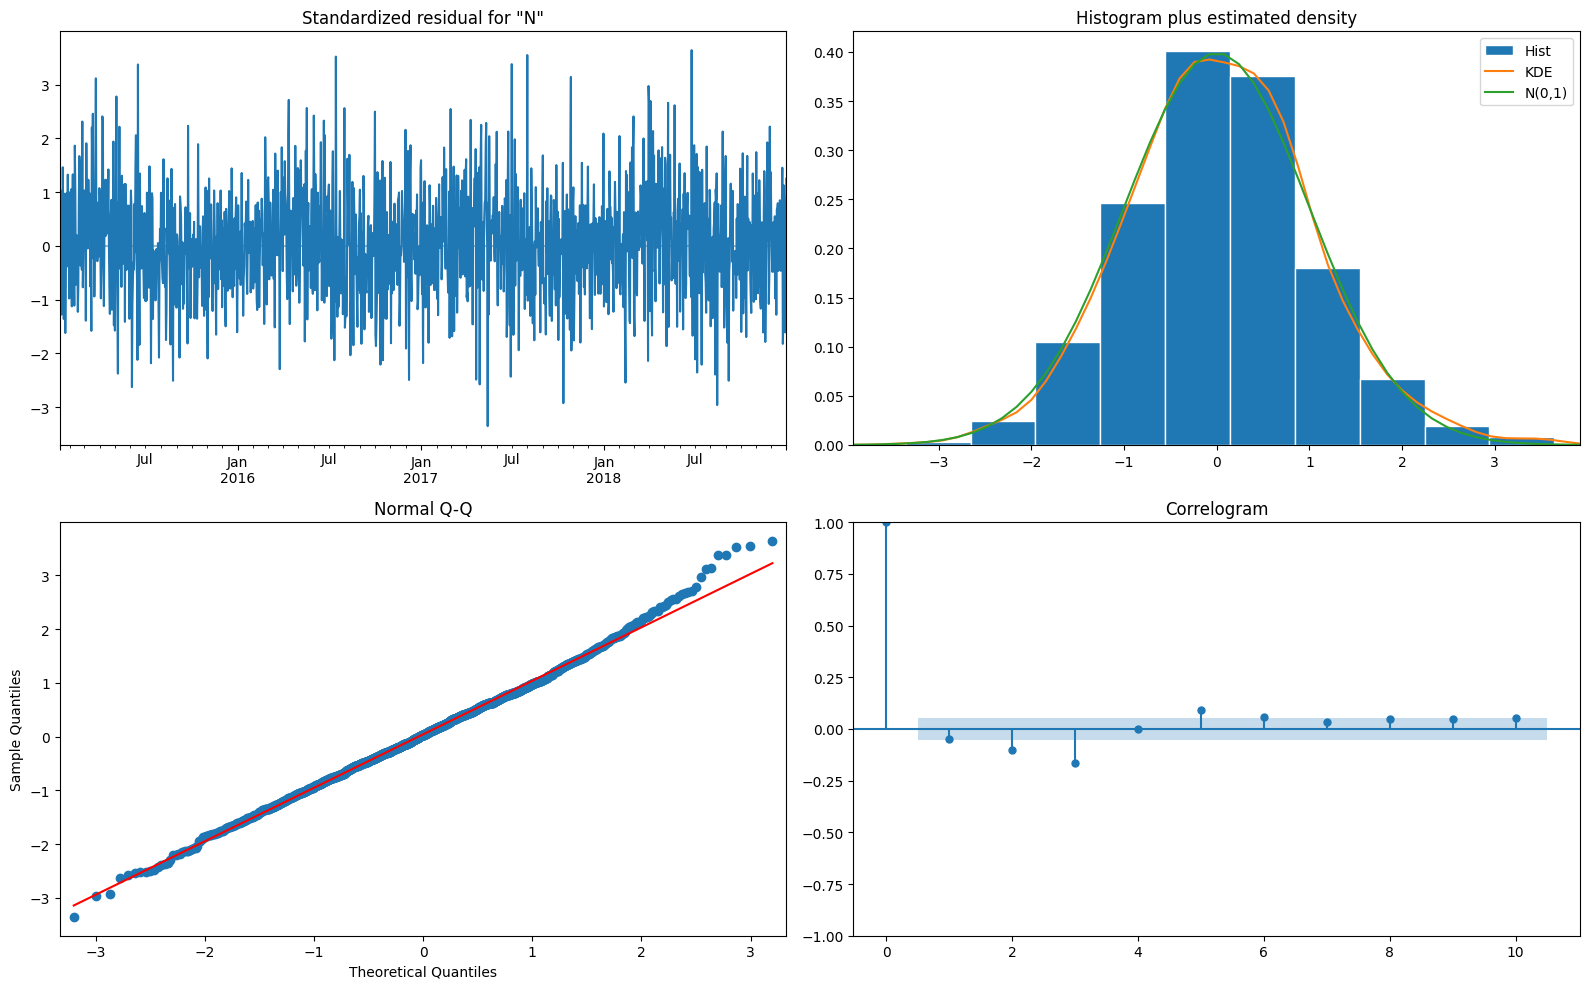

In [20]:
# Print the model summary (coefficients, p-values, AIC, etc.)
print(sarimax_results.summary())

# Plot diagnostic plots: residuals, histogram, Q-Q plot, and correlogram
sarimax_results.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

R² = 1 -  ( Total Sum of Squares (TSS) / Sum of Squared Errors (SSE) )

A Q–Q plot compares the quantiles of residuals (errors) to the quantiles of a standard normal distribution.
- residuals are normally distributed, they will fall along a 45-degree line.

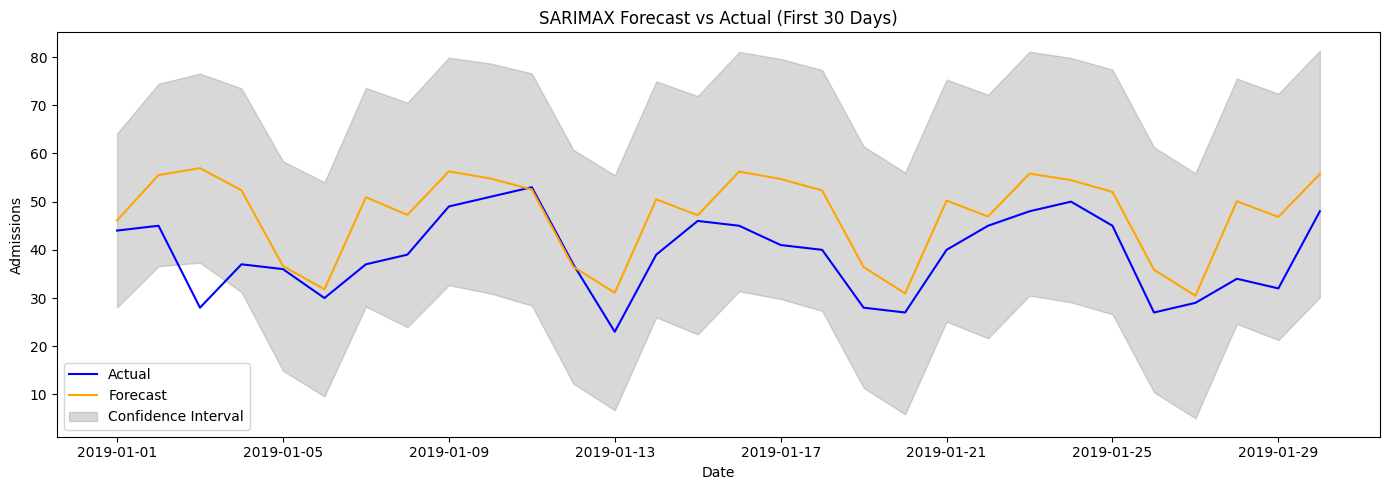

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(y_val[:30].index, y_val[:30], label='Actual', color='blue')
plt.plot(y_val[:30].index, pred_30, label='Forecast', color='orange')
plt.fill_between(y_val[:30].index, conf_30.iloc[:, 0], conf_30.iloc[:, 1],
                 color='gray', alpha=0.3, label='Confidence Interval')
plt.title("SARIMAX Forecast vs Actual (First 30 Days)")
plt.xlabel("Date")
plt.ylabel("Admissions")
plt.legend()
plt.tight_layout()
plt.show()